  Borough Code          Borough Name     LE   
0    E09000001        City of London      -  \
1    E09000002  Barking and Dagenham  76.26   
2    E09000003                Barnet  80.85   
3    E09000004                Bexley  79.68   
4    E09000005                 Brent  78.55   

  Rented from Local Authority or Housing Association   White   Asian  Black   
0                                                  -       -       -      -  \
1                                               39.4   99000   55000  51000   
2                                               12.7  255000   79000  28000   
3                                               16.4  188000   20000  28000   
4                                               20.2  117000  138000  40000   

  Mixed/Other  Proportion of obese children in Year 6 (2022/23)   
0           -                                               NaN  \
1       16000                                             0.317   
2       35000                            

C:\Python310\lib\site-packages\spreg\ml_lag.py:634: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


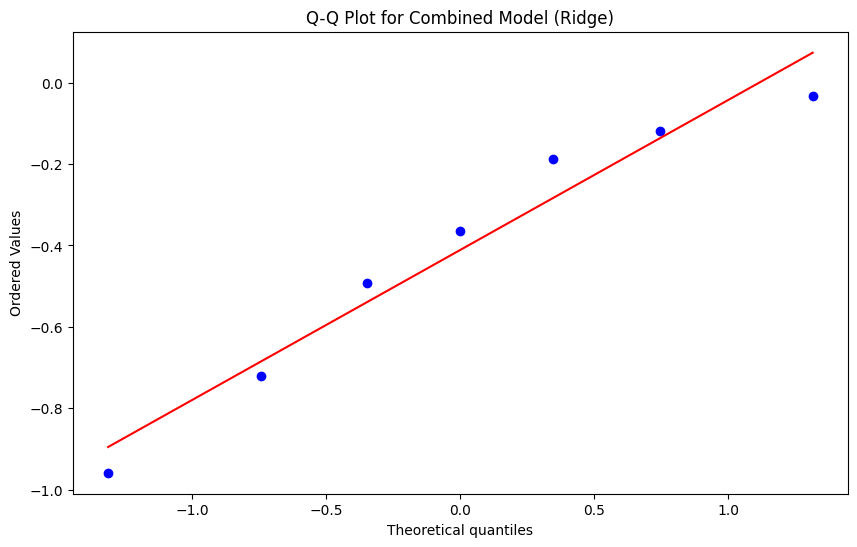

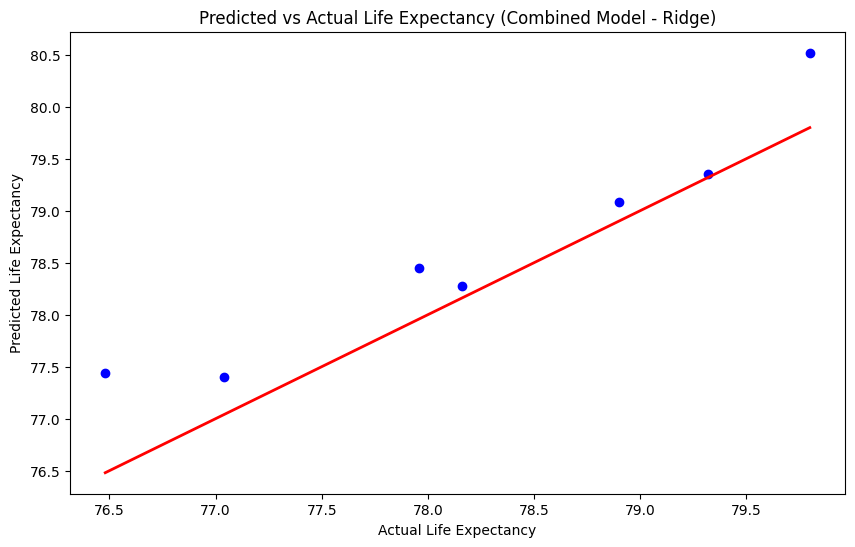

In [4]:
#Combined LE model (includes geospatial regression) - Ridge and Lasso

import pandas as pd  #imports pandas library
import numpy as np  #imports numpy library
from sklearn.model_selection import train_test_split, cross_val_score, KFold  #imports functions for model evaluation
from sklearn.linear_model import Ridge  #imports Ridge model
from sklearn.linear_model import Lasso #imports Lasso model
from sklearn.metrics import mean_squared_error, r2_score  #imports model evaluation metrics
import matplotlib.pyplot as plt  #imports matplotlib for plotting
import seaborn as sns  #imports seaborn for data visualisation
import scipy.stats as stats  #imports scipy for statistical analysis
import geopandas as gpd  #imports geopandas for geospatial data handling
from shapely.geometry import Point  #imports Point for handling geometric data
from libpysal.weights import KNN  #imports KNN for spatial weights
from spreg import ML_Lag  #imports ML_Lag for spatial regression

#Loads the new dataset
file_path = r'C:\Users\alexs\Documents\Masters\Project\Code\EDA\Life Expectancy Data.xlsx' #CHANGE TO YOUR OWN FILEPATH IF YOU WOULD LIKE TO RUN CODE
df = pd.read_excel(file_path)  #reads excel file into dataframe

#Displays the first few rows of the dataframe to inspect
print(df.head())  #prints the first few rows of the dataframe

#Renames columns for clarity
df.columns = ['Borough_Code', 'Borough_Name', 'Life_Expectancy', 'Rented_from_LA_or_HA', 'White', 'Asian', 'Black', 'Mixed_Other', 'Obesity', 'Speak_English_at_Home']

#Ensures all relevant columns are numeric
df['Rented_from_LA_or_HA'] = pd.to_numeric(df['Rented_from_LA_or_HA'], errors='coerce')  
df['Life_Expectancy'] = pd.to_numeric(df['Life_Expectancy'], errors='coerce')  
df['Asian'] = pd.to_numeric(df['Asian'], errors='coerce')  
df['Black'] = pd.to_numeric(df['Black'], errors='coerce')  
df['Mixed_Other'] = pd.to_numeric(df['Mixed_Other'], errors='coerce')  
df['Speak_English_at_Home'] = pd.to_numeric(df['Speak_English_at_Home'], errors='coerce')  

#Checks if 'Obesity' column contains strings with percentages
if df['Obesity'].dtype == object:
    df['Obesity'] = df['Obesity'].str.rstrip('%').astype(float) / 100.0  #converts to float and divides by 100 if percentage
else:
    df['Obesity'] = pd.to_numeric(df['Obesity'], errors='coerce')  #converts to numeric if already a float

#Combines ethnicity columns
df['Minority'] = df['Asian'] + df['Black'] + df['Mixed_Other']  #combines ethnicity columns into 'Minority'
df = df.drop(columns=['Asian', 'Black', 'Mixed_Other', 'White'])  #drops original ethnicity columns

#Drops rows with any NaN values
df = df.dropna()  

#Prints cleaned dataset
print("\nCleaned Data:")  #prints header
print(df.head())  #prints the first few rows of the cleaned dataframe

#Loads and preprocesses the data for the geospatial regression model
boroughs_geojson_path = r'C:\Users\alexs\Documents\Masters\Project\Code\EDA\Healthcare\london_boroughs.json'
boroughs = gpd.read_file(boroughs_geojson_path)  #reads GeoJSON file into GeoDataFrame
boroughs = boroughs.to_crs(epsg=27700)  #converts to British National Grid (EPSG:27700)

hospital_file_path = r'C:\Users\alexs\Documents\Masters\Project\Code\EDA\Healthcare\All_Hospital_Locations.csv'
hospitals = pd.read_csv(hospital_file_path)  #reads CSV file into dataframe
hospitals['geometry'] = hospitals.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)  #creates geometry column
hospitals_gdf = gpd.GeoDataFrame(hospitals, geometry='geometry', crs='EPSG:4326')  #converts to GeoDataFrame with EPSG:4326
hospitals_gdf = hospitals_gdf.to_crs(epsg=27700)  #converts to British National Grid (EPSG:27700)

#Counts hospitals within each borough
boroughs['hospital_count'] = boroughs.apply(lambda borough: hospitals_gdf.within(borough.geometry).sum(), axis=1)  
boroughs['centroid'] = boroughs.centroid  #calculates centroid of each borough

#Defines function to calculate distance to nearest hospital
def nearest_hospital_distance(row, hospitals_gdf):
    centroid = row['centroid']  #gets centroid of borough
    nearest_geom = hospitals_gdf.geometry.distance(centroid).min()  #calculates distance to nearest hospital
    return nearest_geom  #returns distance

#Applies function to calculate distance to nearest hospital
boroughs['nearest_hospital_distance'] = boroughs.apply(nearest_hospital_distance, hospitals_gdf=hospitals_gdf, axis=1)  

life_expectancy_file_path = r'C:\Users\alexs\Documents\Masters\Project\Code\EDA\Life Expectancy and Health\life-expectancy-dataset2(LDNStandard).csv' #CHANGE TO YOUR OWN FILEPATH IF YOU WOULD LIKE TO RUN CODE
life_expectancy = pd.read_csv(life_expectancy_file_path)  #reads CSV file into dataframe

boroughs = boroughs.merge(life_expectancy, left_on='name', right_on='Borough Name')  #merges life expectancy data with boroughs data
boroughs = boroughs.dropna(subset=['hospital_count', 'nearest_hospital_distance', 'LE'])  #drops rows with missing values in specified columns
boroughs['LE'] = pd.to_numeric(boroughs['LE'], errors='coerce')  #converts LE column to numeric
boroughs = boroughs.dropna(subset=['LE'])  #drops rows with NaN values in LE column

#Ensures both datasets contain the same boroughs
common_boroughs = set(df['Borough_Name']).intersection(set(boroughs['name']))  #finds common boroughs in both datasets
df = df[df['Borough_Name'].isin(common_boroughs)]  #filters dataframe to include only common boroughs
boroughs = boroughs[boroughs['name'].isin(common_boroughs)]  #filters GeoDataFrame to include only common boroughs

#Predicts Life Expectancy using selected features
X = df[['Rented_from_LA_or_HA', 'Minority', 'Obesity', 'Speak_English_at_Home']]  #selects features for prediction
y = df['Life_Expectancy']  #sets target variable

#Splits data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

#TO SEE LASSO REGRESSION RESULTS, COMMENT OUT THE CODE BELOW UNTIL YOU REACH THE COMMENTED CODE USING "CTRL /" TO DO IT ALL AT ONCE.
#THEN UNCOMMENT LASSO REGRESSION CODE (CURRENTLY COMMENTED OUT)

#Initialises and trains Ridge regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

#Performs k-fold cross-validation for Ridge regression model
kf = KFold(n_splits=5, shuffle=True, random_state=42)  #initialises k-fold cross-validation
cv_mse_scores_ridge = cross_val_score(ridge_model, X, y, cv=kf, scoring='neg_mean_squared_error')  #calculates MSE scores
cv_r2_scores_ridge = cross_val_score(ridge_model, X, y, cv=kf, scoring='r2')  #calculates R^2 scores

#Prepares data for geospatial regression analysis
y_geo = boroughs['LE'].values  #sets target variable for geospatial regression
X_geo = boroughs[['hospital_count', 'nearest_hospital_distance']].values  #sets features for geospatial regression
X_geo = np.hstack([np.ones((X_geo.shape[0], 1)), X_geo])  #adds constant term to features

#Trains the geospatial model
boroughs_train = boroughs  #sets training data
w_train = KNN.from_dataframe(boroughs_train, k=5)  #creates spatial weights matrix
model_geo = ML_Lag(y_geo, X_geo, w=w_train, name_y='life_expectancy', name_x=['constant', 'hospital_count', 'nearest_hospital_distance'])  #trains spatial lag model

#Predicts using the geospatial model
y_pred_geo = model_geo.predy  #gets predictions from geospatial model

#Combines predictions from both models
ridge_predictions = ridge_model.predict(X)  #gets predictions from Ridge model
X_combined = np.column_stack((ridge_predictions, y_pred_geo))  #combines predictions into one dataset

#Trains meta-model
meta_model = Ridge(alpha=1.0)  #initialises Ridge regression meta-model
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y, test_size=0.2, random_state=42)  #splits combined data into train and test sets
meta_model.fit(X_train_combined, y_train_combined)  #trains meta-model
y_pred_meta = meta_model.predict(X_test_combined)  #gets predictions from meta-model

#Evaluates the combined model
mse_meta = mean_squared_error(y_test_combined, y_pred_meta)  #calculates Mean Squared Error
r2_meta = r2_score(y_test_combined, y_pred_meta)  #calculates R^2 score

#Performs k-fold cross-validation for the combined model
cv_mse_scores_combined = cross_val_score(meta_model, X_combined, y, cv=kf, scoring='neg_mean_squared_error')  #calculates cross-validated MSE scores
cv_r2_scores_combined = cross_val_score(meta_model, X_combined, y, cv=kf, scoring='r2')  #calculates cross-validated R^2 scores

#Evaluates and prints detailed metrics for the combined model
print(f'Combined Model - Mean Squared Error: {mse_meta}')  #prints MSE
print(f'Combined Model - R^2 Score: {r2_meta}')  #prints R^2 score
print(f'Cross-Validation Mean Squared Error (Combined): {-cv_mse_scores_combined.mean()}')  #prints cross-validated MSE
print(f'Cross-Validation R^2 Score (Combined): {cv_r2_scores_combined.mean()}')  #prints cross-validated R^2 score
print(f'Combined Model - Coefficients: {meta_model.coef_}')  #prints model coefficients
print(f'Combined Model - Intercept: {meta_model.intercept_}')  #prints model intercept

#Q-Q plot for Combined Model
plt.figure(figsize=(10, 6))  #sets figure size
stats.probplot(y_test_combined - y_pred_meta, dist="norm", plot=plt)  #plots Q-Q plot
plt.title('Q-Q Plot for Combined Model (Ridge)')  #sets plot title
plt.show()  #displays plot

#Predicted vs actual plot for Combined Model
plt.figure(figsize=(10, 6))  #sets figure size
plt.scatter(y_test_combined, y_pred_meta, color='blue')  #plots predicted vs actual values
plt.plot([y_test_combined.min(), y_test_combined.max()], [y_test_combined.min(), y_test_combined.max()], color='red', linewidth=2)  #plots 45-degree line
plt.title('Predicted vs Actual Life Expectancy (Combined Model - Ridge)')  #sets plot title
plt.xlabel('Actual Life Expectancy')  #sets x-axis label
plt.ylabel('Predicted Life Expectancy')  #sets y-axis label
plt.show()  #displays plot

#AGAIN, UNCOMMENT CODE BELOW AND COMMENT OUT CODE ABOVE TO SEE LASSO MODEL RESULTS

# # Initialises and trains Lasso regression model
# lasso_model = Lasso(alpha=0.1)
# lasso_model.fit(X_train, y_train)  # fits the Lasso model

# # Performs k-fold cross-validation for Lasso regression model
# kf = KFold(n_splits=5, shuffle=True, random_state=42)  # initialises k-fold cross-validation
# cv_mse_scores_lasso = cross_val_score(lasso_model, X, y, cv=kf, scoring='neg_mean_squared_error')  # calculates MSE scores
# cv_r2_scores_lasso = cross_val_score(lasso_model, X, y, cv=kf, scoring='r2')  # calculates R^2 scores

# # Prepares data for geospatial regression analysis
# y_geo = boroughs['LE'].values  # sets target variable for geospatial regression
# X_geo = boroughs[['hospital_count', 'nearest_hospital_distance']].values  # sets features for geospatial regression
# X_geo = np.hstack([np.ones((X_geo.shape[0], 1)), X_geo])  # adds constant term to features

# # Trains the geospatial model
# boroughs_train = boroughs  # sets training data
# w_train = KNN.from_dataframe(boroughs_train, k=5)  # creates spatial weights matrix
# model_geo = ML_Lag(y_geo, X_geo, w=w_train, name_y='life_expectancy', name_x=['constant', 'hospital_count', 'nearest_hospital_distance'])  # trains spatial lag model

# # Predicts using the geospatial model
# y_pred_geo = model_geo.predy  # gets predictions from geospatial model

# # Combines predictions from both models
# lasso_predictions = lasso_model.predict(X)  # gets predictions from Lasso model
# X_combined = np.column_stack((lasso_predictions, y_pred_geo))  # combines predictions into one dataset

# # Trains meta-model
# meta_model = Lasso(alpha=0.1)  # initialises Lasso regression meta-model
# X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y, test_size=0.2, random_state=42)  # splits combined data into train and test sets
# meta_model.fit(X_train_combined, y_train_combined)  # trains meta-model
# y_pred_meta = meta_model.predict(X_test_combined)  # gets predictions from meta-model

# # Evaluates the combined model
# mse_meta = mean_squared_error(y_test_combined, y_pred_meta)  # calculates Mean Squared Error
# r2_meta = r2_score(y_test_combined, y_pred_meta)  # calculates R^2 score

# # Performs k-fold cross-validation for the combined model
# cv_mse_scores_combined = cross_val_score(meta_model, X_combined, y, cv=kf, scoring='neg_mean_squared_error')  # calculates cross-validated MSE scores
# cv_r2_scores_combined = cross_val_score(meta_model, X_combined, y, cv=kf, scoring='r2')  # calculates cross-validated R^2 scores

# # Evaluates and prints detailed metrics for the combined model
# print(f'Combined Model - Mean Squared Error: {mse_meta}')  # prints MSE
# print(f'Combined Model - R^2 Score: {r2_meta}')  # prints R^2 score
# print(f'Cross-Validation Mean Squared Error (Combined): {-cv_mse_scores_combined.mean()}')  # prints cross-validated MSE
# print(f'Cross-Validation R^2 Score (Combined): {cv_r2_scores_combined.mean()}')  # prints cross-validated R^2 score
# print(f'Combined Model - Coefficients: {meta_model.coef_}')  # prints model coefficients
# print(f'Combined Model - Intercept: {meta_model.intercept_}')  # prints model intercept

# # Plots Q-Q plot for Combined Model
# plt.figure(figsize=(10, 6))  # sets figure size
# stats.probplot(y_test_combined - y_pred_meta, dist="norm", plot=plt)  # plots Q-Q plot
# plt.title('Q-Q Plot for Combined Model (Lasso)')  # sets plot title
# plt.show()  # displays plot

# # Plots predicted vs actual plot for Combined Model
# plt.figure(figsize=(10, 6))  # sets figure size
# plt.scatter(y_test_combined, y_pred_meta, color='blue')  # plots predicted vs actual values
# plt.plot([y_test_combined.min(), y_test_combined.max()], [y_test_combined.min(), y_test_combined.max()], color='red', linewidth=2)  # plots 45-degree line
# plt.title('Predicted vs Actual Life Expectancy (Combined Model - Lasso)')  # sets plot title
# plt.xlabel('Actual Life Expectancy')  # sets x-axis label
# plt.ylabel('Predicted Life Expectancy')  # sets y-axis label
# plt.show()  # displays plot


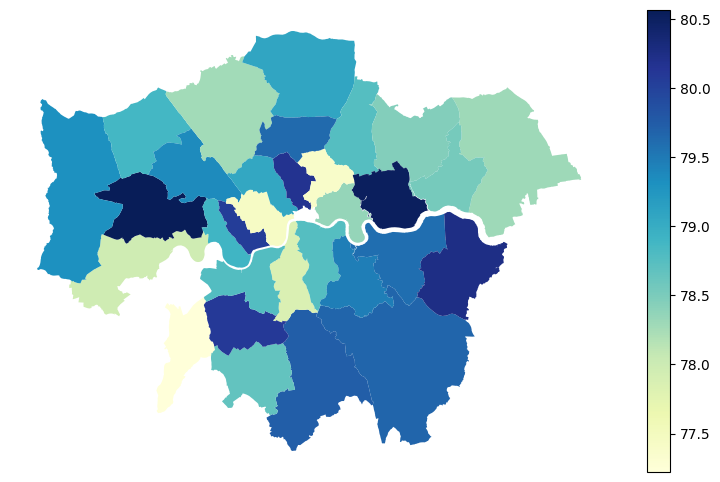

In [2]:
#Run to see model output
import matplotlib.pyplot as plt

#Creates a GeoDataFrame for predictions
boroughs['Predicted_LE'] = meta_model.predict(X_combined)  #predicts Life Expectancy using the meta model
fig, ax = plt.subplots(1, 1, figsize=(10, 6))  #creates a subplot for the map
boroughs.plot(column='Predicted_LE', cmap='YlGnBu', legend=True, ax=ax)  #plots the predicted Life Expectancy by borough
ax.axis('off')  #turns off the axis
#Saves the figure to the specified directory as PDF
map_plot_path = r'C:\Users\alexs\Documents\Masters\Project\Figures\LE Model\Combined_Predicted_LE_Map_Ridge.pdf'  #sets save path
plt.savefig(map_plot_path, format='pdf', bbox_inches='tight')  #saves plot as PDF
plt.show()  #displays plot
